### Exercise

The cosmological growth factor describes the rate of growth of dark matter perturbations in the Universe and is defined as 

$D(a) = \large \frac{5 \Omega_m}{2} \frac{H(a)}{H_0} \int_0^a \frac{da'}{ (a' H(a')/H_0)^3}$,

where $a$ is the scale factor, $\Omega_m$ is the matter density parameter and $H(a)$ is the Hubble rate. In a flat Universe, after radiation domination, we can write H(a) as:

$ H(a) = H_0 \sqrt{(\Omega_m a^{-3} + \Omega_{\Lambda})}$,

where $\Omega_\Lambda$ is the vacuum energy density (in a flat Universe, $\Omega_{\Lambda} = 1 - \Omega_m$).

1) Write a code to calculate the growth factor as a function of a, for given values of the cosmological parameters, using two numerical integration methods of your choice.

2) Plot the growth factor in the scale factor range $a \in [0.1,2]$ for the following values of $\Omega_m$: $0.1$, $0.3$, $0.6$, $1$ (assume a present day expansion rate $H_0 = 67.4 \, {\rm km} \, {\rm s}^{-1}\, {\rm Mpc}^{-1}$). Make a panel with two plots, one for each integration method you chose. Set logscale on x-axis.

3) Optional. For $a = 0.5$, compute the growth factor using the Simpson's rule with varying N and check the convergence rate of the result. Start by sampling the integration interval with ten points and then increase the sample size by a factor of $2$ at each step. How many steps do you need to achieve a final desired accuracy of $10^{-12}$ ?

4) Do cosmic structures grow faster in a matter dominated Universe, or in a Universe with a cosmological constant?

In [61]:
import numpy as np
import scipy as sp
import scipy.integrate as integrate
from matplotlib import pyplot as plt

In [62]:
# Hubble parameter as a function of a (I also include curvature for generality)
def hubble(a):
    
    omegak = 1.0 - omegam - omegav
    H = H0*np.sqrt((omegam*a**(-3) + omegak*a**(-2) + omegav))
    
    return H

In [55]:
def integrand(a):

    omegak = 1.0 - omegam - omegav
    
    if (a < 1e-20):
         integrand = 0.0
    else:
        H = hubble(a)
        integrand = H0**3/(H**3*a**3)
    
    return integrand


In [56]:
# Integral with simpson rule (N = number of points in the interval)

def growth_simp(a,N):

    C = (5*omegam*hubble(a))/(2*H0)
    da = a/float(N) 
    grid = np.arange(0.0,a,da)
    y = [ ]
    for x in grid:
        y.append(integrand(x))
    growth = C*integrate.simpson(y,grid)
    
    return growth

In [57]:
# Integral with Romberg

def growth_rom(integrand,a):

    C = (5*omegam*hubble(a))/(2*H0)
    growth = C*integrate.romberg(integrand,0.0,a)
    
    return growth

#### Calculating and plotting the growth factor

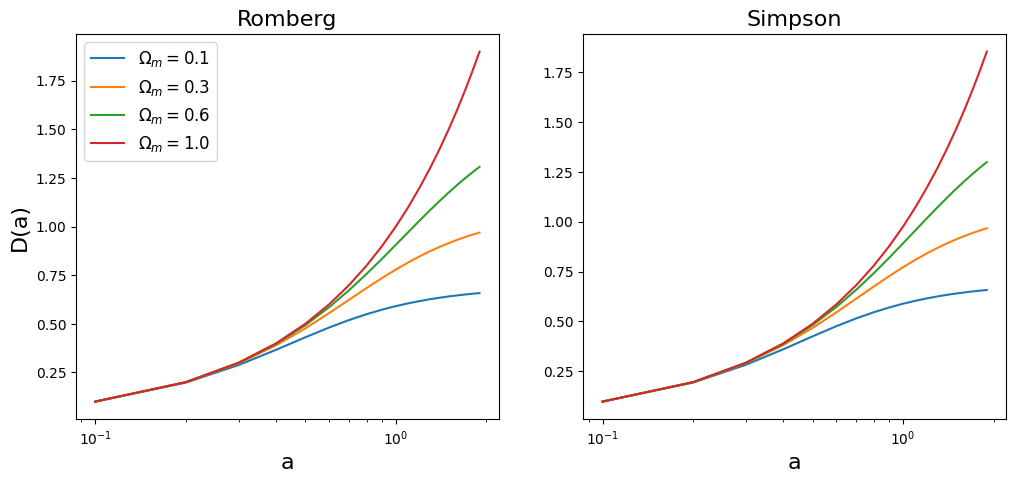

In [63]:
# Sampling points in 0.1 < a < 2
amin = 0.1
amax = 2.0
step = 0.1
alist = np.arange(amin,amax,step)

# Number of points for Simpson's method
N = 100

# Hubble rate today
H0 = 67.4

# Plot layout
fig, axs = plt.subplots(1,2,figsize=(12,5))
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_xlabel('a',fontsize=16)
axs[1].set_xlabel('a',fontsize=16)
axs[0].set_ylabel('D(a)',fontsize=16)
axs[0].set_title('Romberg',fontsize=16)
axs[1].set_title('Simpson',fontsize=16)


# Calculating growth factor for all sampled values of the scale factor.
# Using Romberg and Simpson.
for omegam in [0.1,0.3,0.6,1.0]:
    
    gfrom = [ ]
    gfsimp = [ ]
    omegav = 1.0 - omegam
    
    for a in alist:
        # With Romberg
        gfrom.append(growth_rom(integrand,a))
        # With Simpson's
        gfsimp.append(growth_simp(a,N))
    
    # Plotting
    axs[0].plot(alist,gfrom,label='$\Omega_m =$' + str('%.1f' % (omegam)))
    axs[0].legend(fontsize=12)
    axs[1].plot(alist,gfsimp)

plt.show()

#### Accuracy and convergence check using adaptive Simpson's integration

In [64]:
def simp(func,a,b,tol):
    
    demomode = True
        
    # Initial number of sampled points
    N = 10
    
    # 1/3*f(a) + 1/3*f(b)
    s = (1./3.)*func(a) + (1./3.)*func(b)
    
    # Starting with N points
    h = (b-a)/N
    s1odd = 0.
    for k in range(1,N,2):
        s1odd += func(a + k*h)
    s1even = 0.
    for k in range(2,N,2):
        s1even += func(a+k*h)
    
    # Simpson's rule with N points in [a,b]
    simp1N = h*(s + (4./3.)*s1odd + (2./3.)*s1even)
    
    if demomode:
            print(N, simp1N)
    
    acc = tol+1.
    
    while (acc > tol):
        # Now doubling the number of points and updating h
        N = 2*N
        h = (b-a)/N
        # All points in previous interval (odd+even) are
        # now the even points in the new interval.
        s2even = s1odd + s1even
        # Now getting s2odd
        s2odd = 0.
        for k in range(1,N,2):
            s2odd += func(a+k*h)
        # Simpson's rule with 2N points in the sample
        simp2N = h*(s + (4./3.)*s2odd + (2./3.)*s2even)
    
        acc = ((1./15.)*abs(simp2N-simp1N))/abs(simp2N)
        
        # Update and loop
        s1even, s1odd = s2even, s2odd
        simp1N = simp2N
        
        if demomode:
            print(N, simp2N)
        
        # Exit loop if N > 1e6
        if (N > 1e6):
            print(' ')
            print('The required accuracy could not be reached with N=1e6 points.')
            print('Stopping here, N =', N, '; acc =', acc)
            break
    
    return simp2N

In [65]:
# Finding the number of points/step to achieve 1e-12 accuracy.

a = 0.5
tol = 1e-12

growth = simp(integrand,0.0,a,tol)

10 0.07071850966554898
20 0.07071206673622876
40 0.07071092385650815
80 0.07071072157581391
160 0.07071068580189514
320 0.07071067947693682
640 0.07071067835877139
1280 0.070710678161102
2560 0.0707106781261585
5120 0.07071067811998126
10240 0.07071067811888931
20480 0.07071067811869614
